In [1]:
import os 
import torch
import torch.nn as nn
import torch.nn.functional as F 
import numpy as np
import gym
import warnings
from torch.distributions.categorical import Categorical
warnings.simplefilter("ignore")
from robot_model import *
torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cpu")

In [2]:
from gymnasium import spaces

class CDPR4_env(CDPR4):
    def __init__(self, start_state=np.array([.0, .0, 1.0, .0, .0, .0]), desired_state=np.array([.0, .0, 2.0, .0, .0, .0]), pos=np.array([.0, .0, 1.0]), params=params, approx=1, mass=1):
        super().__init__(pos=np.array([.0, .0, 1.]), params=params, approx=1, mass=1)

        self.start_state = start_state.copy()  # start position 1m on Z
        self.cur_state = np.array([.0, .0, 1., .0, .0, .0]) # X=[pos, vel] in control
        self.reward = 0 # reward 0 is 0 error in position, closer position to desired -> higher reward 
        self.desired_state = desired_state
        self.v = np.array([.0, .0, .0])
        self.control = np.array([.0, .0, .0, .0])
    
        self.max_speed = 10
        self.max_force = 15 
        self.dt = 0.1
        
        self.action_space = spaces.Discrete(16) # [_,_,_,_] each place 0/1
        self.action_decoder = {
            i: np.array([int(b) for b in f'{i:04b}']) for i in range(16)
        }
        self.observation_space = spaces.Box(low=np.array([-1.154, -1.404, .0, -self.max_speed, -self.max_speed, -self.max_speed]), 
                                            high=np.array([1.154, 1.404, 3.220,  self.max_speed, self.max_speed, self.max_speed]))
        self._max_episode_steps = 500 # default in gymnasium env is 1000
        self._elapsed_steps = 0
        
    def reset(self):
        state = self.observation_space.sample()
        state_d = self.observation_space.sample()
        self.desired_state = state_d
        
        self._elapsed_steps = 0
        self.pos = state[:3].flatten()
        self.v = state[3:].flatten()
        
        self.reward = -np.linalg.norm(self.pos - self.desired_state[:3].flatten())
        
        return state, state_d, {}
    
    def step(self, action):
        pos = self.cur_state[:3].flatten()
        vel = self.cur_state[3:].flatten()
        m = self.m

        dt = self.dt
        u = self.max_force*self.action_decoder[action].reshape((4,1))
        costs = np.linalg.norm(pos - self.desired_state[:3].flatten())
        costs += 0.5*np.linalg.norm(vel - self.desired_state[3:].flatten())
        
        dXdt = self.B() @ u + np.array([.0, .0, .0, .0, .0, -g]).reshape((6,1))
        new_vel = vel + dXdt[:3].flatten()*dt
        new_pos = pos + vel*dt + 0.5*dXdt[3:].flatten()*dt**2
        self.pos = new_pos
        self.v = new_vel

        state = np.hstack((new_pos, new_vel))
        self.cur_state = state
        terminated = np.allclose(self.cur_state, self.desired_state, atol=1e-03) # reached desired position
        self._elapsed_steps += 1
        
        truncated = False
        if self._elapsed_steps >= self._max_episode_steps:
            truncated = True
        
        # state = np.hstack((state, self.desired_state))
        return state, -costs, terminated, truncated, {} #
        

In [3]:
env = CDPR4_env()

In [ ]:
class ActorCriticNetwork(nn.Module):
    def __init__(self, n_observations, n_actions, fc1_dims=2048, fc2_dims=1024):
        super(ActorCriticNetwork, self).__init__()
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions

        self.fc1 = nn.Linear(n_observations, self.fc1_dims)  # Assuming input size is 4
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.v = nn.Linear(self.fc2_dims, 1)
        self.pi = nn.Linear(self.fc2_dims, n_actions)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))

        v = self.v(x)
        pi = F.softmax(self.pi(x), dim=-1)

        return v, pi


In [5]:
from torch.distributions import Categorical
import torch.optim as optim

class Agent:
    def __init__(self, alpha=0.0003, gamma=0.99, n_observations=12, n_actions=16):
        self.gamma = gamma
        self.n_actions = n_actions
        self.action = None
        self.action_space = [i for i in range(self.n_actions)]

        self.actor_critic = ActorCriticNetwork(n_observations=n_observations, n_actions=n_actions)
        self.optimizer = optim.Adam(self.actor_critic.parameters(), lr=alpha)

    def choose_action(self, observation):
        # state = torch.tensor([observation], dtype=torch.float32)
        _, probs = self.actor_critic(observation)

        action_probabilities = Categorical(probs)
        action = action_probabilities.sample()
        log_prob = action_probabilities.log_prob(action)
        self.action = action

        return action.item()

    def learn(self, state, reward, state_, done):
        state = np.hstack((state, env.desired_state))
        state_ = np.hstack((state_, env.desired_state))
        state = torch.tensor([state], dtype=torch.float32)        
        state_ = torch.tensor([state_], dtype=torch.float32)
        reward = torch.tensor(reward, dtype=torch.float32)

        self.optimizer.zero_grad()

        state_value, probs = self.actor_critic(state)
        state_value_, _ = self.actor_critic(state_)
        state_value = torch.squeeze(state_value)
        state_value_ = torch.squeeze(state_value_)

        action_probs = Categorical(probs)
        log_prob = action_probs.log_prob(self.action)

        delta = reward + self.gamma * state_value_ * (1 - int(done)) - state_value
        actor_loss = -log_prob * delta.detach()
        critic_loss = delta.pow(2)
        total_loss = actor_loss + critic_loss

        total_loss.backward()
        self.optimizer.step()

In [6]:
from tqdm import tqdm
agent = Agent(alpha=1e-5, n_observations=2*env.observation_space.shape[0], n_actions=env.action_space.n)
n_games = 2400

best_score = -150
score_history = []

pbar = tqdm(range(n_games), desc="Training Progress")

for i in pbar:
    observation, desired_state, _ = env.reset()
    obs_plus_des = torch.hstack((torch.from_numpy(observation), torch.from_numpy(desired_state)))
    done = False
    trunc = False
    score = 0
    while not (done or trunc):
        action = agent.choose_action(obs_plus_des.float())
        observation_, reward, done, trunc, info = env.step(action)
        score += reward
        agent.learn(observation, reward, observation_, done)
        observation = observation_
        obs_plus_des = torch.hstack((torch.from_numpy(observation), torch.from_numpy(desired_state)))
    score_history.append(score)
    avg_score = np.mean(score_history[-100:])

    if score > best_score:
        best_score = score
        # torch.save(agent.actor_critic.state_dict(), f'models/07_ActorCritic_separate_linearReward_21_11_24_reward{int(score)}')
        
    pbar.set_postfix({
            'Episode Reward': f'{float(score):.5f}',
            'avg_score': f'{float(avg_score):.5f}',
            'pos':f'{env.pos}'
            
        })
    # print('episode ', i, 'score %.1f' % score, 'avg_score %.1f' % avg_score)

Training Progress: 100%|██████████| 2400/2400 [1:13:55<00:00,  1.85s/it, Episode Reward=-4702.35778, avg_score=-3276.75464, pos=[ 0.03708309  0.04540399 -0.51854212]]              


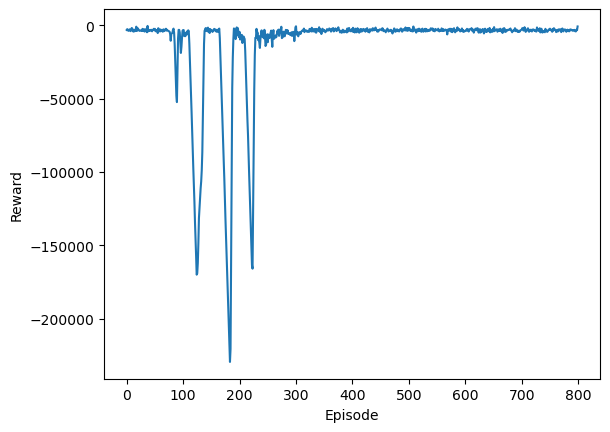

In [11]:
import matplotlib.pyplot as plt

plt.plot(range(800), score_history[:800])
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()